# Advanced MVO - custom objectives

PyPortfolioOpt has implemented some of the most common objective functions (e.g `min_volatility`, `max_sharpe`, `max_quadratic_utility`, `efficient_risk`, `efficient_return`). However, sometimes yoy may have an idea for a different objective function.

In this cookbook recipe, we cover:

- Mininimising transaction costs
- Custom convex objectives
- Custom nonconvex objectives

## Acquiring data

As discussed in the previous notebook, assets are an exogenous input (i.e you must come up with a list of tickers). We will use `yfinance` to download data for thesee tickers

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
tickers = ["BLK", "BAC", "AAPL", "TM", "WMT",
           "JD", "INTU", "MA", "UL", "CVS",
           "DIS", "AMD", "NVDA", "PBI", "TGT"]

In [3]:
ohlc = yf.download(tickers, period="max")

[*********************100%***********************]  15 of 15 completed


In [4]:
prices = ohlc["Adj Close"]
prices.tail()

,AAPL,AMD,BAC,BLK,CVS,DIS,INTU,JD,MA,NVDA,PBI,TGT,TM,UL,WMT
Date,,,,,,,,,,,,,,,
2021-01-22,139.070007,92.790001,31.549999,735.049988,74.120003,172.779999,374.850006,94.910004,328.989990,548.500000,7.19,191.910004,147.949997,59.660000,146.330002
2021-01-25,142.919998,94.129997,31.160000,722.979980,73.209999,171.889999,374.429993,98.379997,329.190002,546.130005,7.53,190.149994,146.720001,60.970001,146.199997
2021-01-26,143.160004,94.709999,30.940001,721.849976,74.230003,169.559998,374.799988,96.970001,327.700012,537.409973,13.63,187.699997,145.979996,60.900002,147.509995
2021-01-27,142.059998,88.839996,29.830000,697.789978,72.419998,163.029999,363.109985,90.089996,315.489990,516.710022,10.81,178.279999,142.639999,59.340000,143.839996
2021-01-28,137.089996,87.519997,30.320000,719.909973,72.610001,171.880005,369.950012,91.410004,324.279999,522.039978,9.27,183.580002,143.300003,59.080002,143.750000


## Expected returns and risk models

In this notebook, we will use James-Stein shrinkage and semicovariance (which only penalises downside risk).

In [5]:
import pypfopt
pypfopt.__version__

'1.3.1'

In [6]:
from pypfopt import risk_models, expected_returns
from pypfopt import plotting

mu = expected_returns.capm_return(prices)
S = risk_models.semicovariance(prices)

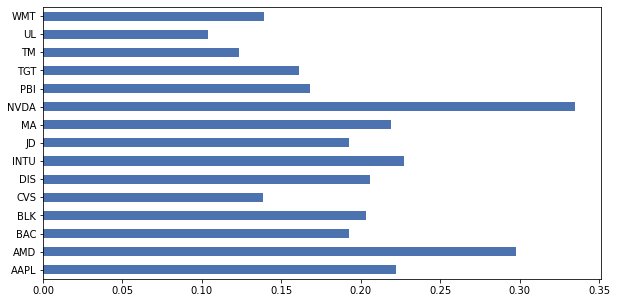

In [7]:
mu.plot.barh(figsize=(10,5));

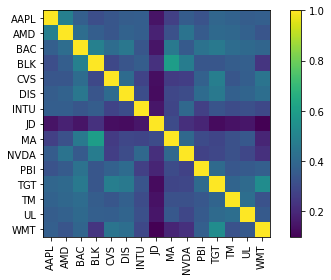

In [8]:
plotting.plot_covariance(S, plot_correlation=True);

## Min volatility with a transaction cost objective

Let's say that you already have a portfolio, and want to now optimize it. It could be quite expensive to completely reallocate, so you may want to take into account transaction costs. PyPortfolioOpt provides a simple objective to account for this.

Note: this objective will not play nicely with `max_sharpe`.

In [9]:
# Pretend that you started with a default-weight allocation
initial_weights = np.array([1/len(tickers)] * len(tickers))

In [10]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(mu, S)

# 1% broker commission
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.01)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.02233),
             ('AMD', 0.0),
             ('BAC', 0.00295),
             ('BLK', 0.06667),
             ('CVS', 0.06667),
             ('DIS', 0.06667),
             ('INTU', 0.06667),
             ('JD', 0.24971),
             ('MA', 0.06667),
             ('NVDA', 0.05834),
             ('PBI', 0.06667),
             ('TGT', 0.06667),
             ('TM', 0.06667),
             ('UL', 0.06667),
             ('WMT', 0.06667)])

Notice that many of the weights are 0.06667, i.e your original equal weight. In fact, the only change has been an allocation of AMD's weight to JD. If we lower the cost `k`, the allocation will change more:

In [11]:
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.0),
             ('AMD', 0.0),
             ('BAC', 0.0),
             ('BLK', 0.06667),
             ('CVS', 0.03844),
             ('DIS', 0.0),
             ('INTU', 0.01533),
             ('JD', 0.48839),
             ('MA', 0.16953),
             ('NVDA', 0.0),
             ('PBI', 0.0),
             ('TGT', 0.00077),
             ('TM', 0.06667),
             ('UL', 0.08754),
             ('WMT', 0.06667)])

The optimizer seems to really like JD. The reason for this is that it is highly anticorrelated to other assets (notice the dark column in the covariance plot). Hence, historically, it adds a lot of diversification. But it is dangerous to place too much emphasis on what happened in the past, so we may want to limit the asset weights. 

In addition, we notice that 4 stocks have now been allocated zero weight, which may be undesirable. Both of these problems can be fixed by adding an [L2 regularisation objective](https://pyportfolioopt.readthedocs.io/en/latest/EfficientFrontier.html#more-on-l2-regularisation). 

In [12]:
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)
ef.add_objective(objective_functions.L2_reg)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.06179),
             ('AMD', 0.05379),
             ('BAC', 0.06202),
             ('BLK', 0.07042),
             ('CVS', 0.06667),
             ('DIS', 0.06506),
             ('INTU', 0.06667),
             ('JD', 0.0775),
             ('MA', 0.0734),
             ('NVDA', 0.06399),
             ('PBI', 0.06508),
             ('TGT', 0.06591),
             ('TM', 0.06909),
             ('UL', 0.07073),
             ('WMT', 0.0679)])

This has had too much of an evening-out effect. After all, if the resulting allocation is going to be so close to equal weights, we may as well stick with our initial allocation. We can reduce the strength of the L2 regularisation by reducing `gamma`:

In [13]:
ef = EfficientFrontier(mu, S)
ef.add_objective(objective_functions.transaction_cost, w_prev=initial_weights, k=0.001)
ef.add_objective(objective_functions.L2_reg, gamma=0.05)  # default is 1
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.01915),
             ('AMD', 0.0),
             ('BAC', 0.00684),
             ('BLK', 0.09548),
             ('CVS', 0.06667),
             ('DIS', 0.04251),
             ('INTU', 0.06071),
             ('JD', 0.19403),
             ('MA', 0.13693),
             ('NVDA', 0.0299),
             ('PBI', 0.04005),
             ('TGT', 0.05035),
             ('TM', 0.08321),
             ('UL', 0.10267),
             ('WMT', 0.07152)])

In [14]:
ef.portfolio_performance(verbose=True);

Expected annual return: 18.0%
Annual volatility: 9.4%
Sharpe Ratio: 1.69


This portfolio is now reasonably balanced, but also puts significantly more weight on JD. 

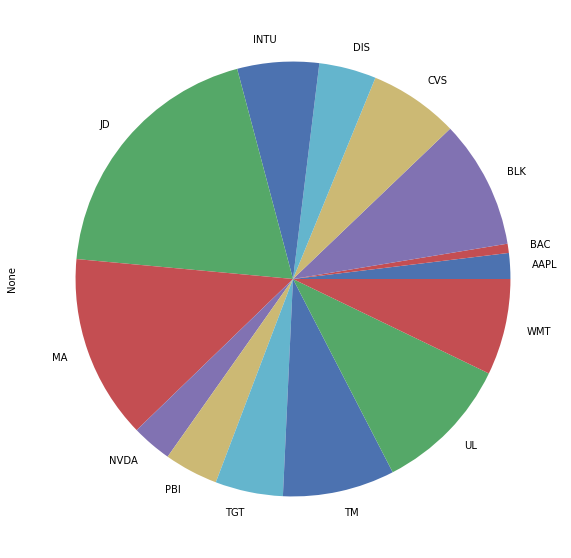

In [15]:
pd.Series(weights).plot.pie(figsize=(10,10));

## Custom convex objectives

PyPortfolioOpt comes with the following built-in objective functions, as of v1.2.1:

- Portfolio variance (i.e square of volatility)
- Portfolio return
- Sharpe ratio
- L2 regularisation (minimising this reduces nonzero weights)
- Quadratic utility
- Transaction cost model (a simple one)

However, you may want have a different objective. If this new objective is **convex**, you can optimize a portfolio with the full benefit of PyPortfolioOpt's modular syntax, for example adding other constraints and objectives.

To demonstrate this, we will minimise the **logarithmic-barrier** function suggested in the paper 60 Years of Portfolio Optimization, by Kolm et al (2014):

$$f(w, S, k) = w^T S w - k \sum_{i=1}^N \ln w$$

We must first convert this mathematical objective into the language of cvxpy. Cvxpy is a powerful modelling language for convex optimization problems. It is clean and easy to use, the only caveat is that objectives must be expressed with `cvxpy` functions, a list of which can be found [here](https://www.cvxpy.org/tutorial/functions/index.html).

In [16]:
import cvxpy as cp

# Note: functions are minimised. If you want to maximise an objective, stick a minus sign in it.
def logarithmic_barrier_objective(w, cov_matrix, k=0.1):
    log_sum = cp.sum(cp.log(w))
    var = cp.quad_form(w, cov_matrix)
    return var - k * log_sum

Once we have written the objective function, we can just use the `ef.convex_objective()` to minimise the objective.

In [17]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.2))
ef.convex_objective(logarithmic_barrier_objective, cov_matrix=S, k=0.001)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.03824),
             ('AMD', 0.02618),
             ('BAC', 0.03724),
             ('BLK', 0.07674),
             ('CVS', 0.05578),
             ('DIS', 0.04616),
             ('INTU', 0.05245),
             ('JD', 0.2),
             ('MA', 0.11598),
             ('NVDA', 0.04185),
             ('PBI', 0.04538),
             ('TGT', 0.04891),
             ('TM', 0.06917),
             ('UL', 0.08254),
             ('WMT', 0.06337)])

In [18]:
ef.portfolio_performance(verbose=True);

Expected annual return: 18.7%
Annual volatility: 10.1%
Sharpe Ratio: 1.66


This is compatible with all the constraints discussed in the previous recipe. Let's say that we want to limit JD's weight to 15%.

In [19]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.2))
jd_index = ef.tickers.index("JD")  # get the index of JD
ef.add_constraint(lambda w: w[jd_index] <= 0.15)
ef.convex_objective(logarithmic_barrier_objective, cov_matrix=S, k=0.001)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.03914),
             ('AMD', 0.0264),
             ('BAC', 0.0378),
             ('BLK', 0.08259),
             ('CVS', 0.05832),
             ('DIS', 0.04759),
             ('INTU', 0.05474),
             ('JD', 0.15),
             ('MA', 0.13295),
             ('NVDA', 0.0432),
             ('PBI', 0.04705),
             ('TGT', 0.05057),
             ('TM', 0.07351),
             ('UL', 0.08928),
             ('WMT', 0.06684)])

## Custom nonconvex objectives

In some cases, you may be trying to optimize for nonconvex objectives. Optimization in general is a very hard problem, so please be aware that you may have mixed results in that case. Convex problems, on the other hand, are well understood and can be solved with nice theoretical guarantees.

PyPortfolioOpt does offer some functionality for nonconvex optimization, but it is not really encouraged. In particular, nonconvex optimization is not compatible with PyPortfolioOpt's modular constraints API.

As an example, we will use the Deviation Risk Parity objective from Kolm et al (2014). Because we are not using a convex solver, we don't have to define it using `cvxpy` functions.

In [20]:
def deviation_risk_parity(w, cov_matrix):
    diff = w * np.dot(cov_matrix, w) - (w * np.dot(cov_matrix, w)).reshape(-1, 1)
    return (diff ** 2).sum().sum()

In [21]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.12))
ef.nonconvex_objective(deviation_risk_parity, ef.cov_matrix)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.05548),
             ('AMD', 0.02632),
             ('BAC', 0.05766),
             ('BLK', 0.07681),
             ('CVS', 0.07115),
             ('DIS', 0.06542),
             ('INTU', 0.06962),
             ('JD', 0.07815),
             ('MA', 0.0788),
             ('NVDA', 0.06256),
             ('PBI', 0.06566),
             ('TGT', 0.06743),
             ('TM', 0.07492),
             ('UL', 0.07692),
             ('WMT', 0.0731)])

However, let's say we now want to enforce that JD has a weight of 10%. In the convex case, this would be as simple as:

```python
ef.add_objective(lambda w: w[jd_index] == 0.10)
```

But unfortunately, scipy does not allow for such intuitive syntax. You will need to rearrange your constraints to make them either `=0` or `<= 0`. 

```python
constraints = [
    # First constraint
     {"type": "eq",  # equality constraint,
      "fun": lambda w: w[1] - 0.2},  # the equality functions are assumed to = 0 
      
    # Second constraint
    {"type": "ineq",  # inequality constraint
     "fun": lambda w: w[0] - 0.5}   # inequality functions <= 0
]
```

For more information, you can consult the [scipy docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), but they aren't very helpful.

In [22]:
ef = EfficientFrontier(mu, S, weight_bounds=(0.01, 0.12))

ef.nonconvex_objective(
    deviation_risk_parity,
    objective_args=S,
    weights_sum_to_one=True,
    constraints=[
        {"type": "eq", "fun": lambda w: w[jd_index] - 0.10},  
    ],
)

weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.05542),
             ('AMD', 0.0298),
             ('BAC', 0.05735),
             ('BLK', 0.07367),
             ('CVS', 0.06894),
             ('DIS', 0.06406),
             ('INTU', 0.0676),
             ('JD', 0.1),
             ('MA', 0.07529),
             ('NVDA', 0.06145),
             ('PBI', 0.06419),
             ('TGT', 0.06579),
             ('TM', 0.0721),
             ('UL', 0.07376),
             ('WMT', 0.07059)])

## More examples of nonconvex objectives

The scipy format is not intuitive and is hard to explain, so here are a bunch of examples (adapted from the tests). Some of these are actually convex, so you should use `convex_objective` instead. 

In [23]:
# Another example of deviation risk parity
def deviation_risk_parity(w, cov_matrix):
    n = cov_matrix.shape[0]
    rp = (w * (cov_matrix @ w)) / cp.quad_form(w, cov_matrix)
    return cp.sum_squares(rp - 1 / n).value

ef = EfficientFrontier(mu, S)
ef.nonconvex_objective(deviation_risk_parity, ef.cov_matrix)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.04324),
             ('AMD', 0.03142),
             ('BAC', 0.04275),
             ('BLK', 0.07606),
             ('CVS', 0.05896),
             ('DIS', 0.05053),
             ('INTU', 0.0562),
             ('JD', 0.1765),
             ('MA', 0.1006),
             ('NVDA', 0.04714),
             ('PBI', 0.05017),
             ('TGT', 0.05296),
             ('TM', 0.06948),
             ('UL', 0.07936),
             ('WMT', 0.06461)])

In [24]:
# Deviation risk parity with weight bound on the first asset
ef = EfficientFrontier(mu, S)
ef.nonconvex_objective(deviation_risk_parity, 
                       ef.cov_matrix, 
                       constraints=[{"type":"eq", "fun":lambda w: w[0] - 0.1}])
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.1),
             ('AMD', 0.03391),
             ('BAC', 0.0477),
             ('BLK', 0.07674),
             ('CVS', 0.06093),
             ('DIS', 0.05398),
             ('INTU', 0.05745),
             ('JD', 0.10687),
             ('MA', 0.09381),
             ('NVDA', 0.05099),
             ('PBI', 0.05455),
             ('TGT', 0.05561),
             ('TM', 0.06824),
             ('UL', 0.07546),
             ('WMT', 0.06377)])

In [25]:
# Market-neutral efficient risk.
# Please use ef.efficient_risk() for anything serious.
target_risk = 0.19
ef = EfficientFrontier(mu, S, weight_bounds=(None, None))

# Weights sum to zero
weight_constr = {"type": "eq", "fun": lambda w: np.sum(w)}

# Portfolio vol less than target vol
risk_constr = {
    "type": "eq",
    "fun": lambda w: target_risk ** 2 - np.dot(w.T, np.dot(ef.cov_matrix, w)),
}
constraints = [weight_constr, risk_constr]

ef.nonconvex_objective(
    lambda w, mu: -w.T.dot(mu),  # min negative return i.e max return
    objective_args=(ef.expected_returns),
    weights_sum_to_one=False,
    constraints=constraints,
)
weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.09548),
             ('AMD', 0.16658),
             ('BAC', 0.00681),
             ('BLK', -0.12506),
             ('CVS', -0.17303),
             ('DIS', 0.21509),
             ('INTU', 0.1153),
             ('JD', 0.16446),
             ('MA', 0.65232),
             ('NVDA', 0.41921),
             ('PBI', -0.04438),
             ('TGT', 0.00676),
             ('TM', -0.48244),
             ('UL', -0.86122),
             ('WMT', -0.15589)])

In [26]:
# Utility objective - you could actually use ef.max_quadratic_utility
ef = EfficientFrontier(mu, S)

def utility_obj(weights, mu, cov_matrix, k=1):
    return -weights.dot(mu) + k * np.dot(weights.T, np.dot(cov_matrix, weights))

ef.nonconvex_objective(
    utility_obj,
    objective_args=(ef.expected_returns, ef.cov_matrix, 1)
    # default is for weights to sum to 1
)

weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.0),
             ('AMD', 0.04621),
             ('BAC', 0.0),
             ('BLK', 0.0),
             ('CVS', 0.0),
             ('DIS', 0.0),
             ('INTU', 0.0),
             ('JD', 0.0),
             ('MA', 0.0),
             ('NVDA', 0.95379),
             ('PBI', 0.0),
             ('TGT', 0.0),
             ('TM', 0.0),
             ('UL', 0.0),
             ('WMT', 0.0)])

In [27]:
ef.weights.sum()

1.0000000000000002

In [28]:
# Kelly objective with weight bounds on zeroth asset
def kelly_objective(w, e_returns, cov_matrix, k=3):
    variance = np.dot(w.T, np.dot(cov_matrix, w))
    objective = variance * 0.5 * k - np.dot(w, e_returns)
    return objective

lower_bounds, upper_bounds = 0.01, 0.3
ef = EfficientFrontier(mu, S)
ef.nonconvex_objective(
    kelly_objective,
    objective_args=(ef.expected_returns, ef.cov_matrix, 1000),
    constraints=[
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "ineq", "fun": lambda w: w[0] - lower_bounds},
        {"type": "ineq", "fun": lambda w: upper_bounds - w[0]},
    ],
)

weights = ef.clean_weights()
weights

OrderedDict([('AAPL', 0.06667),
             ('AMD', 0.06667),
             ('BAC', 0.06667),
             ('BLK', 0.06667),
             ('CVS', 0.06667),
             ('DIS', 0.06667),
             ('INTU', 0.06667),
             ('JD', 0.06667),
             ('MA', 0.06667),
             ('NVDA', 0.06667),
             ('PBI', 0.06667),
             ('TGT', 0.06667),
             ('TM', 0.06667),
             ('UL', 0.06667),
             ('WMT', 0.06667)])